In [1]:
import numpy as np
import keras
import tensorflow as tf
from keras import backend as K
from extra_keras_metrics import average_precision_at_k
from IPython.display import SVG
from keras.utils.vis_utils import plot_model
import pydot as pyd
from keras.utils.vis_utils import model_to_dot
from keras.layers import Input, Dense, Embedding, Lambda, Reshape, Flatten, Average
from keras.models import Model
from keras.backend import mean, max
from keras.preprocessing.sequence import pad_sequences

keras.utils.vis_utils.pydot = pyd

Using TensorFlow backend.


In [2]:
tf.__version__

'1.13.1'

In [3]:
max_history = 50
category_size = 100


In [4]:
hidden_layer1_size = 256
hidden_layer2_size = 128
hidden_layer3_size = 64

input_embedding_size = 64


In [5]:
purchase_cols = [x for x in range(max_history)]
product_click_cols = [x for x in range(max_history, max_history*2)]
promotion_click_cols = [x for x in range(max_history*2, max_history*3)]
seq_category_cols = [purchase_cols, product_click_cols, promotion_click_cols]


numeric_cols = [x for x in range(max_history*3, max_history*3 + 10)]
single_category_cols = {105:3,106:5,107:10}   ## such as location : unique_value_size

In [6]:
category_embeddings = Embedding(output_dim=input_embedding_size, input_dim = category_size, 
                       input_length=max_history, mask_zero=True, name='category_embeddings')

In [35]:
def seq_categorical_input(name):
    
    seq = Input(shape=(max_history,), dtype='int32', name=name)
    input_embeddings = category_embeddings(seq)
    avg = Lambda(lambda x: mean(x, axis=1), name= name + '_avg_embedding')
    avg_embedding = avg(input_embeddings)
    
    maxf = Lambda(lambda x: max(x, axis=1), name = name + '_max_embedding')
    max_embedding = maxf(input_embeddings)
    
    return seq, avg_embedding   #keras.layers.add([avg_embedding, max_embedding])

In [29]:
def singe_categorical_input(name, unique_size):
    single = Input(shape=(1,), dtype='int32', name=name)
    embeddings = Embedding(output_dim=input_embedding_size, input_dim = unique_size, 
                       input_length=1, name=name + '_embedding')(single)
    embeddings = Flatten(name = 'flatten_' + name)(embeddings)
    return single, embeddings

In [9]:
def continous_inputs(size=None, name='numeric'):
    inp = Input(shape=(size,), dtype='float32', name=name)
    return inp, inp

In [40]:
def RecoDNN():

    seqs = []
    for i, grp in enumerate(seq_category_cols):
        seqs.append(seq_categorical_input('categorical_' + str(i)))
        
    singles = []
    for col in single_category_cols:
        singles.append(singe_categorical_input(str(col), single_category_cols[col]))

    nums = continous_inputs(len(numeric_cols))
    
    inp_layer =  [s[0] for s in seqs]
    inp_layer += [s[0] for s in singles]
    inp_layer.append(nums[0])
    inp_embed = [s[1] for s in seqs]
    inp_embed += [s[1] for s in singles]
    inp_embed.append(nums[1])
    
    v = Dense(hidden_layer1_size, activation='relu')(keras.layers.concatenate(inp_embed)) 
    v = Dense(hidden_layer2_size, activation='relu')(v)
    v = Dense(hidden_layer3_size, activation='relu', name='user_embedding')(v)
    output = Dense(category_size, activation='softmax', name='softmax_layer')(v)
    model = Model(inputs=inp_layer, outputs=[output])
    
    return model

# Fake data

In [11]:
data_size = 10000


In [12]:

data1 = np.random.randint(category_size, size=(data_size, max_history))
data2 = np.random.randint(category_size, size=(data_size, max_history))
data3 = np.random.randint(category_size, size=(data_size, max_history))

single1 = np.random.randint(3, size=(data_size, 1))
single2 = np.random.randint(5, size=(data_size, 1))
single3 = np.random.randint(10, size=(data_size, 1))
num1 = np.random.random(size=(data_size, len(numeric_cols)))

labels = np.random.randint(category_size, size=(data_size, 1))
one_hot_labels = keras.utils.to_categorical(labels, num_classes=category_size)



* raw features extraction and integration
* sample and build raw training set
* feature creation, transformation and normalization

# Train model

In [50]:
model = RecoDNN()


In [51]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
categorical_0 (InputLayer)      (None, 50)           0                                            
__________________________________________________________________________________________________
categorical_1 (InputLayer)      (None, 50)           0                                            
__________________________________________________________________________________________________
categorical_2 (InputLayer)      (None, 50)           0                                            
__________________________________________________________________________________________________
105 (InputLayer)                (None, 1)            0                                            
__________________________________________________________________________________________________
106 (Input

In [52]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

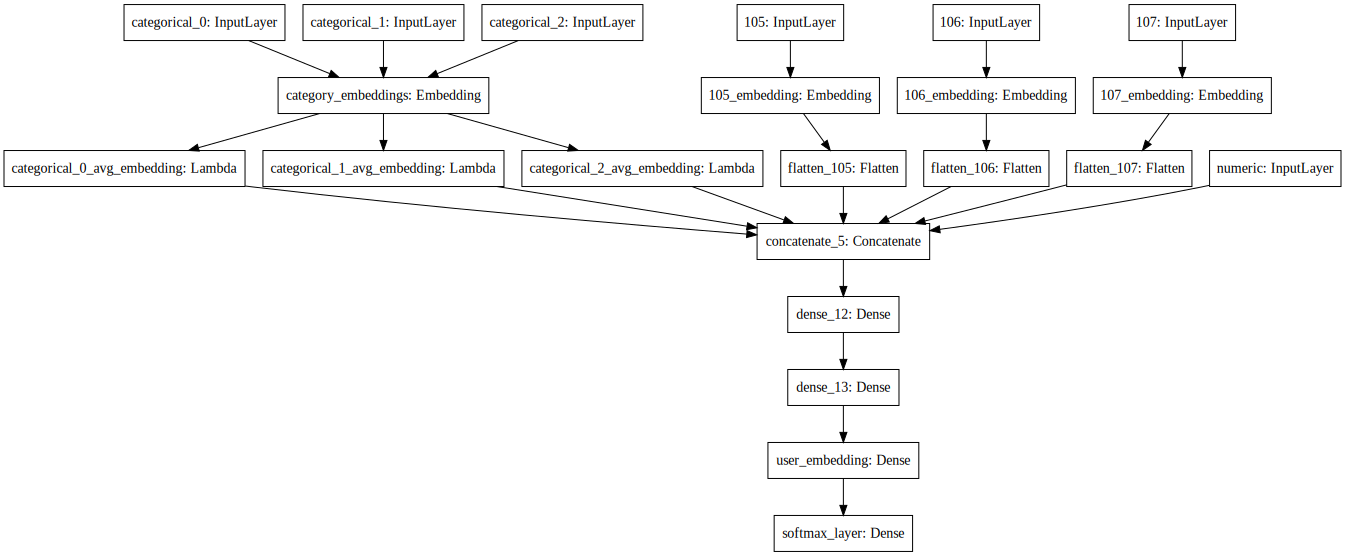

In [53]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [54]:
model.compile(loss='categorical_crossentropy',
                       optimizer='adam',
                       metrics=['accuracy'])

In [55]:
model.fit(x=[data1, data2, data3, single1, single2, single3, num1], 
          y=one_hot_labels, epochs=70, batch_size=32)

Epoch 1/70
10000/10000 [==============================] - 1s 145us/step - loss: 4.6068 - acc: 0.0115
Epoch 2/70
10000/10000 [==============================] - 1s 91us/step - loss: 4.5982 - acc: 0.0137
Epoch 3/70
10000/10000 [==============================] - 1s 90us/step - loss: 4.5678 - acc: 0.0220
Epoch 4/70
10000/10000 [==============================] - 1s 92us/step - loss: 4.4743 - acc: 0.0314
Epoch 5/70
10000/10000 [==============================] - 1s 93us/step - loss: 4.3153 - acc: 0.0559
Epoch 6/70
10000/10000 [==============================] - 1s 96us/step - loss: 4.0767 - acc: 0.0841
Epoch 7/70
10000/10000 [==============================] - 1s 92us/step - loss: 3.7725 - acc: 0.1363
Epoch 8/70
10000/10000 [==============================] - 1s 93us/step - loss: 3.4301 - acc: 0.1877
Epoch 9/70
10000/10000 [==============================] - 1s 95us/step - loss: 3.0715 - acc: 0.2536
Epoch 10/70
10000/10000 [==============================] - 1s 95us/step - loss: 2.7223 - acc: 0.321

KeyboardInterrupt: 

In [56]:
model.evaluate([data1, data2, data3, single1, single2, single3, num1], y=one_hot_labels, batch_size=32)

10000/10000 [==============================] - 0s 39us/step


[0.0003717466065660119, 1.0]

In [57]:
model.layers[-1].get_weights()[0].shape   # category embedding matrix


(64, 100)

In [58]:
model.layers[-1].output

<tf.Tensor 'softmax_layer_1/Softmax:0' shape=(?, 100) dtype=float32>

In [49]:
model.layers[-2].output  ### user embedding


<tf.Tensor 'user_embedding_1/Relu:0' shape=(?, 64) dtype=float32>

* make it easy to use and config
* implement some new ideas beforehand
* some document work
* data loader interface
* training env preparation